<a href="https://colab.research.google.com/github/Zhalil24/BreastMRI-CNN-Classification/blob/main/ResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!cp "/content/drive/MyDrive/data_set_zip/breast_mri_dataset.rar" /content/
!unrar x /content/breast_mri_dataset.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8061.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8253.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8422.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8489.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8575.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8605.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8659.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8680.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8693.jpg      78%  OK 
Extracti

In [10]:
# 2. Veri Hazırlama ve Augmentation
mri_mean = [0.485, 0.456, 0.406]
mri_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mri_mean, mri_std)
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mri_mean, mri_std)
    ]),
}


data_dir = '/content/breast_mri_dataset'

# Model Oluşturma Fonksiyonu
def build_model():
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

    # Katman Dondurma Stratejisi
    # conv1 ve layer1 dondurulur
    for name, child in model.named_children():
        if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1']:
            for param in child.parameters():
                param.requires_grad = False
        else:
            for param in child.parameters():
                param.requires_grad = True

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    return model.to(device)

In [11]:
# 3. Diferansiyel Öğrenme Oranı Ayarı
def get_optimizer(model):
    optimizer = optim.Adam([
        {'params': model.layer2.parameters(), 'lr': 1e-5},
        {'params': model.layer3.parameters(), 'lr': 5e-5},
        {'params': model.layer4.parameters(), 'lr': 1e-4},
        {'params': model.fc.parameters(), 'lr': 1e-3}
    ])
    return optimizer

In [12]:
# 4. Eğitim Fonksiyonu
def train_model(fold, train_loader, val_loader, num_epochs=10):
    model = build_model()
    optimizer = get_optimizer(model)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        v_loss, v_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                v_loss += loss.item() * inputs.size(0)
                v_corrects += torch.sum(preds == labels.data)

        val_loss = v_loss / len(val_loader.dataset)
        val_acc = v_corrects.double() / len(val_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        print(f'Fold {fold} Epoch {epoch}: Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    return model, history

In [13]:
# 5. Ana Çalıştırma Döngüsü

full_train_val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms['train'])

labels = full_train_val_dataset.targets
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_histories = []
final_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n--- FOLD {fold+1} BAŞLIYOR ---")
    train_sub = torch.utils.data.Subset(full_train_val_dataset, train_idx)
    val_sub = torch.utils.data.Subset(datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms['val_test']), val_idx)

    train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=32, shuffle=False)

    final_model, history = train_model(fold+1, train_loader, val_loader, num_epochs=10)
    all_histories.append(history)



--- FOLD 1 BAŞLIYOR ---
Fold 1 Epoch 0: Train Loss: 0.4255 Acc: 0.7866 | Val Loss: 0.3813 Acc: 0.8506
Fold 1 Epoch 1: Train Loss: 0.2365 Acc: 0.8934 | Val Loss: 0.1329 Acc: 0.9450
Fold 1 Epoch 2: Train Loss: 0.1702 Acc: 0.9267 | Val Loss: 0.1146 Acc: 0.9504
Fold 1 Epoch 3: Train Loss: 0.1521 Acc: 0.9393 | Val Loss: 0.0755 Acc: 0.9721
Fold 1 Epoch 4: Train Loss: 0.1098 Acc: 0.9559 | Val Loss: 0.0574 Acc: 0.9768
Fold 1 Epoch 5: Train Loss: 0.0972 Acc: 0.9612 | Val Loss: 0.0713 Acc: 0.9697
Fold 1 Epoch 6: Train Loss: 0.0927 Acc: 0.9667 | Val Loss: 0.0686 Acc: 0.9706
Fold 1 Epoch 7: Train Loss: 0.0744 Acc: 0.9708 | Val Loss: 0.0375 Acc: 0.9854
Fold 1 Epoch 8: Train Loss: 0.0682 Acc: 0.9728 | Val Loss: 0.0318 Acc: 0.9878
Fold 1 Epoch 9: Train Loss: 0.0584 Acc: 0.9770 | Val Loss: 0.0378 Acc: 0.9860

--- FOLD 2 BAŞLIYOR ---
Fold 2 Epoch 0: Train Loss: 0.4149 Acc: 0.7939 | Val Loss: 0.1824 Acc: 0.9156
Fold 2 Epoch 1: Train Loss: 0.2340 Acc: 0.8953 | Val Loss: 0.1382 Acc: 0.9418
Fold 2 Epoch 2

In [14]:
# 6. Test Seti Değerlendirme
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms['val_test'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

final_model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy()[:, 1])

In [15]:
# 7. Metriklerin Yazdırılması
print("\n--- TEST SETİ PERFORMANS SONUÇLARI ---")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_true, y_probs):.4f}")


--- TEST SETİ PERFORMANS SONUÇLARI ---
Accuracy: 0.9847
Precision: 0.9949
Recall: 0.9745
F1-Score: 0.9846
ROC-AUC: 0.9993


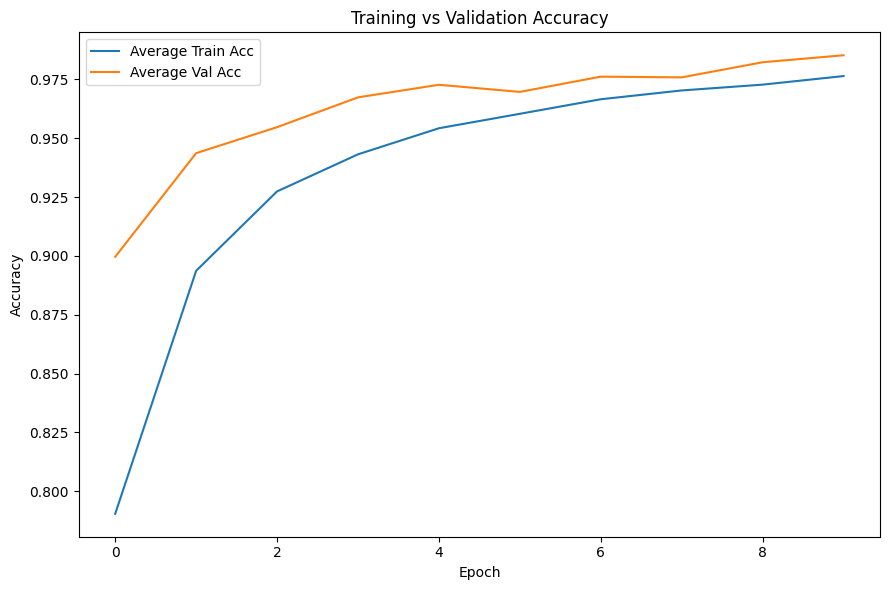

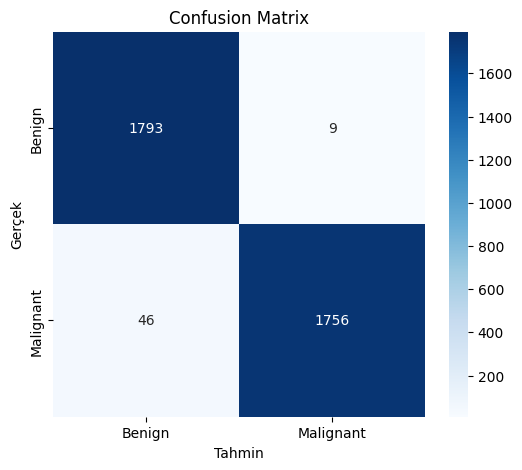

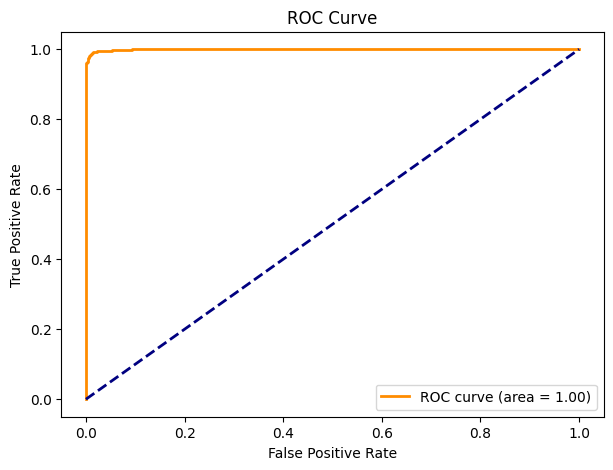

In [16]:


# Ortalama performans metriklerini hesapla
avg_train_acc = np.mean([h['train_acc'] for h in all_histories], axis=0)
avg_val_acc = np.mean([h['val_acc'] for h in all_histories], axis=0)
avg_train_loss = np.mean([h['train_loss'] for h in all_histories], axis=0)
avg_val_loss = np.mean([h['val_loss'] for h in all_histories], axis=0)

test_labels = y_true
test_preds = y_pred
test_probs = y_probs
epochs = range(len(avg_train_acc))

plt.figure(figsize=(9, 6))
plt.plot(epochs, avg_train_acc, label='Average Train Acc')
plt.plot(epochs, avg_val_acc, label='Average Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()


fpr, tpr, _ = roc_curve(test_labels, test_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(test_labels, test_probs):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()